In [1]:
import sys
import pandas as pd
import nflreadpy as nfl

sys.path.append('../py')
from preprocess import preprocess
from nflplotlib import nflplot as nfp

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
sup_data = pd.read_csv('../data/supplementary_data.csv')
tracking_input = pd.read_csv('../data/train/input_2023_w01.csv')
tracking_output = pd.read_csv('../data/train/output_2023_w01.csv')

/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_51268/766476731.py:1: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  sup_data = pd.read_csv('../data/supplementary_data.csv')


In [3]:
games, plays, players, tracking = preprocess.process_data(tracking_input, tracking_output, sup_data)
team_desc = preprocess.fetch_team_desc()

2025-12-13 16:54:39,842 - INFO - Joined input and output tracking data: 819 unique plays, 737 unique nfl_ids
2025-12-13 16:54:39,843 - INFO - Standardizing direction of play and players to be left to right
2025-12-13 16:54:39,907 - INFO - Approximating missing speed, acceleration and direction values
2025-12-13 16:54:40,041 - INFO - Correlation results for imputations: s_approx: speed R²=0.9864 | a_approx: accel R²=0.0340 | dir_approx: dir R²=0.0469
2025-12-13 16:54:40,069 - INFO - Joining supplemental data to plays DataFrame
2025-12-13 16:54:40,084 - INFO - Loading NFL PBP data for season 2023
2025-12-13 16:54:40,085 - INFO - Loading pbp from local parquet file
2025-12-13 16:54:40,225 - INFO - Mapping player IDs to nfl_id using seasonal rosters
2025-12-13 16:54:40,225 - INFO - Rosters for season 2023 already cached, loading from parquet
2025-12-13 16:54:50,158 - WARNING - Dropping gpid 2023091001_3216 with no passer and no QB
2025-12-13 16:54:50,200 - WARNING - Dropping gpid 202309100

In [4]:
epa_results = (
    pd.read_csv('../data/results/epa_preds.csv')
    .merge(
        plays[['gpid', 'absolute_yardline_number', 'ball_land_x', 'ball_land_y','num_frames_output']],
        on='gpid', how='left')
    .assign(
        x=lambda x: x['absolute_yardline_number'] + x['x'],
        start_x=lambda x: x['absolute_yardline_number'] + x['start_x'],
    )
)
epa_results.head()

,gpid,safety_nfl_id,sample_type,x,y,vx,vy,start_x,start_y,start_dir,start_s,predicted_epa,absolute_yardline_number,ball_land_x,ball_land_y,num_frames_output
0,2023090700_101,46137,original,62.870000,4.630000,2.600729,-7.501987,53.08,20.04,326.31,2.59,-1.632715,42,63.259998,-0.22,21
1,2023090700_101,46137,simulated,72.955746,15.432903,6.819203,-1.580656,53.08,20.04,326.31,2.59,1.079599,42,63.259998,-0.22,21
2,2023090700_101,46137,simulated,73.159746,16.682307,6.904139,-1.154496,53.08,20.04,326.31,2.59,1.119911,42,63.259998,-0.22,21
3,2023090700_101,46137,simulated,73.280823,17.979474,6.963866,-0.710329,53.08,20.04,326.31,2.59,1.169611,42,63.259998,-0.22,21
4,2023090700_101,46137,simulated,73.310887,19.321168,6.995585,-0.248563,53.08,20.04,326.31,2.59,1.223893,42,63.259998,-0.22,21


In [13]:
int_results = (
    pd.read_csv('../data/results/int_preds.csv')
    .merge(
        plays[['gpid', 'absolute_yardline_number', 'ball_land_x', 'ball_land_y','num_frames_output']],
        on='gpid', how='left')
    .assign(
        x=lambda x: x['absolute_yardline_number'] + x['x'],
        start_x=lambda x: x['absolute_yardline_number'] + x['start_x'],
    )
)
int_results.head()

,gpid,safety_nfl_id,sample_type,x,y,vx,vy,start_x,start_y,start_dir,start_s,predicted_int,absolute_yardline_number,ball_land_x,ball_land_y,num_frames_output
0,2023090700_101,46137,original,62.870000,4.630000,2.600729,-7.501987,53.08,20.04,326.31,2.59,0.000009,42,63.259998,-0.22,21
1,2023090700_101,46137,simulated,72.955746,15.432903,6.819203,-1.580656,53.08,20.04,326.31,2.59,0.000036,42,63.259998,-0.22,21
2,2023090700_101,46137,simulated,73.159746,16.682307,6.904139,-1.154496,53.08,20.04,326.31,2.59,0.000039,42,63.259998,-0.22,21
3,2023090700_101,46137,simulated,73.280823,17.979474,6.963866,-0.710329,53.08,20.04,326.31,2.59,0.000041,42,63.259998,-0.22,21
4,2023090700_101,46137,simulated,73.310887,19.321168,6.995585,-0.248563,53.08,20.04,326.31,2.59,0.000045,42,63.259998,-0.22,21


In [5]:
gpids = epa_results.gpid.unique()

len(gpids)

213

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata
from scipy.spatial import ConvexHull
from matplotlib.path import Path

def plot_safety_reach_heatmap(df, model_type="epa", tracking=None):
    """
    Plot a heatmap of predicted EPA or Interception probability for a safety's reach,
    including all players, ball path, and vectors.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain:
        - x, y, vx, vy for simulated/original points
        - start_x, start_y, start_dir, start_s for the safety origin
        - predicted_epa OR predicted_int depending on model_type
        - sample_type ('original' or 'simulated')
    model_type : str
        "epa" or "int". Determines which prediction column to use.
    tracking : pd.DataFrame, optional
        Full tracking data for the play, needed to plot other players.
    """

    # Choose prediction column
    pred_col = "predicted_epa" if model_type == "epa" else "predicted_int"

    # Filter to safety
    safety_nfl_id = df["safety_nfl_id"].iloc[0]
    df = df.query('safety_nfl_id == @safety_nfl_id')

    # Safety start info
    start_x = df["start_x"].iloc[0]
    start_y = df["start_y"].iloc[0]
    dir_rad = np.deg2rad(df["start_dir"].iloc[0])
    speed = df["start_s"].iloc[0]
    vec_dx = np.cos(dir_rad) * speed
    vec_dy = np.sin(dir_rad) * speed

    # Simulated points
    sim = df[df["sample_type"] == "simulated"]
    xs, ys = sim["x"].values, sim["y"].values
    preds = sim[pred_col].values

    # Interpolation grid
    grid_res = 200
    xi = np.linspace(xs.min(), xs.max(), grid_res)
    yi = np.linspace(ys.min(), ys.max(), grid_res)
    xi_grid, yi_grid = np.meshgrid(xi, yi)
    zi_grid = griddata((xs, ys), preds, (xi_grid, yi_grid), method='cubic', fill_value=np.nan)

    # Mask outside convex hull
    points = np.column_stack((xs, ys))
    hull = ConvexHull(points)
    hull_path = Path(points[hull.vertices])
    mask = hull_path.contains_points(np.column_stack((xi_grid.ravel(), yi_grid.ravel()))).reshape(xi_grid.shape)
    zi_grid[~mask] = np.nan

    # --- Plot ---
    plt.figure(figsize=(10, 6))
    cmap = "RdYlGn_r" if model_type=="epa" else "coolwarm"
    im = plt.contourf(xi_grid, yi_grid, zi_grid, levels=40, cmap=cmap, alpha=0.8, zorder=3)
    plt.contour(xi_grid, yi_grid, zi_grid, levels=10, alpha=0.3, linewidths=0.5, zorder=4)

    # Safety start
    plt.scatter(start_x, start_y, color="grey", s=50, label="Safety start", zorder=6, edgecolors='black', linewidths=2)
    plt.arrow(start_x, start_y, vec_dx, vec_dy, head_width=0.5, head_length=0.8, fc="black", ec="black", linewidth=1, zorder=5)

    # Safety actual end
    original = df[df["sample_type"] == "original"].iloc[0]
    plt.scatter(original["x"], original["y"], color="black", s=50, label="Safety actual end", zorder=6, edgecolors='black', linewidths=2)

    # Ball start
    if tracking is not None:
        gpid = df["gpid"].iloc[0]
        ball_start_frame = tracking.query('gpid == @gpid & ~pass_thrown').frame_id.max()
        ball_start = tracking.query('gpid == @gpid & frame_id == @ball_start_frame & player_side == "Ball"')
        plt.scatter(ball_start.x, ball_start.y, marker='x', color='brown', s=100, label='Ball Start', zorder=7)
        ball_start_x, ball_start_y = ball_start.x.values[0], ball_start.y.values[0]
    else:
        ball_start_x, ball_start_y = None, None

    # Ball landing
    ball_x, ball_y = df["ball_land_x"].iloc[0], df["ball_land_y"].iloc[0]
    plt.scatter(ball_x, ball_y, marker='x', color='red', s=100, label='Ball Landing', zorder=7)

    # Ball path
    if ball_start_x is not None:
        plt.plot([ball_start_x, ball_x], [ball_start_y, ball_y], color='brown', linestyle='--', label='Ball Path', zorder=2)

    # Absolute yardline
    yardline = df["absolute_yardline_number"].iloc[0]
    plt.axvline(x=yardline, color='purple', linestyle='--', label='Absolute Yardline', zorder=2)

    # Plot last frame offense and defense
    if tracking is not None:
        last_frame = tracking.query('gpid == @gpid').frame_id.max()
        last_frame_data = tracking.query('gpid == @gpid & frame_id == @last_frame')
        defenders = last_frame_data.query('player_side == "Defense" & nfl_id != @safety_nfl_id')
        offenses = last_frame_data.query('player_side == "Offense"')

        # Scatter positions
        plt.scatter(defenders.x, defenders.y, color='orange', s=50, label='Defenders', zorder=6, edgecolors='black', linewidths=1)
        plt.scatter(offenses.x, offenses.y, color='cyan', s=50, label='Offense', zorder=9, edgecolors='black', linewidths=1)

        # Movement arrows
        for df_arrow, color in zip([offenses, defenders], ['black','black']):
            for _, row in df_arrow.iterrows():
                rad = np.deg2rad(row['dir'])
                plt.arrow(row['x'], row['y'], np.cos(rad)*row['s']*0.5, np.sin(rad)*row['s']*0.5,
                          head_width=0.3, head_length=0.5, fc=color, ec=color, linewidth=1, zorder=7)

    # --- Final touches ---
    plt.axis('equal')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    cbar = plt.colorbar(im)
    cbar.set_label("Predicted EPA" if model_type=="epa" else "Predicted Int Probability")
    plt.legend(bbox_to_anchor=(-.5, 1), loc='upper left')
    plt.show()


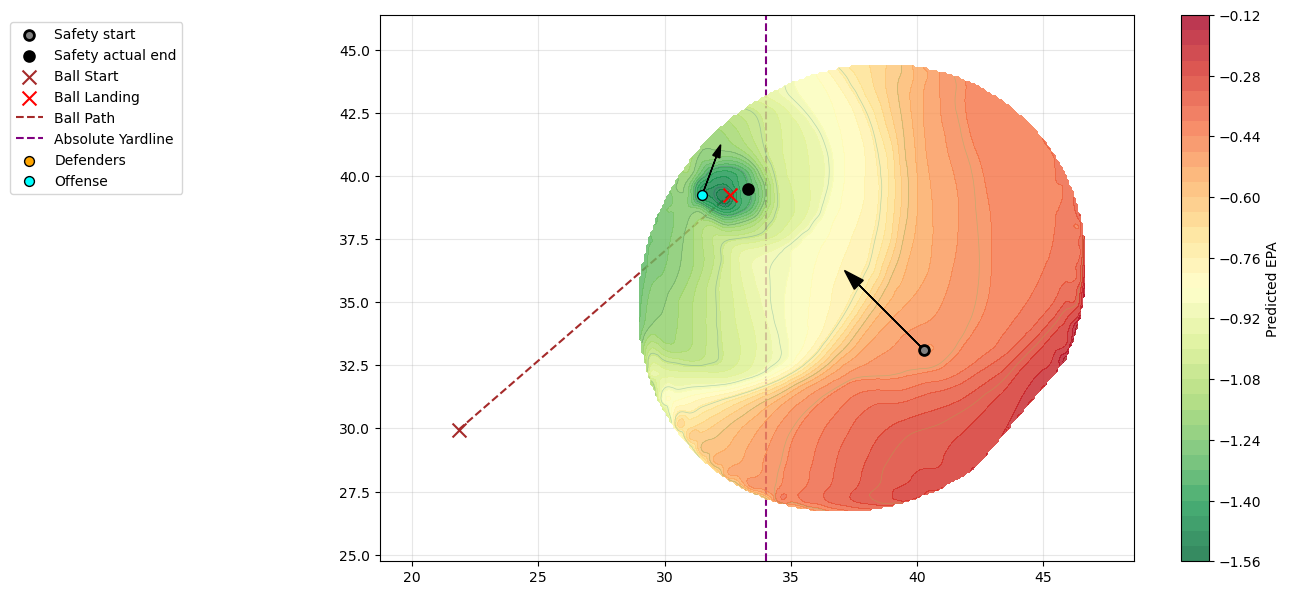

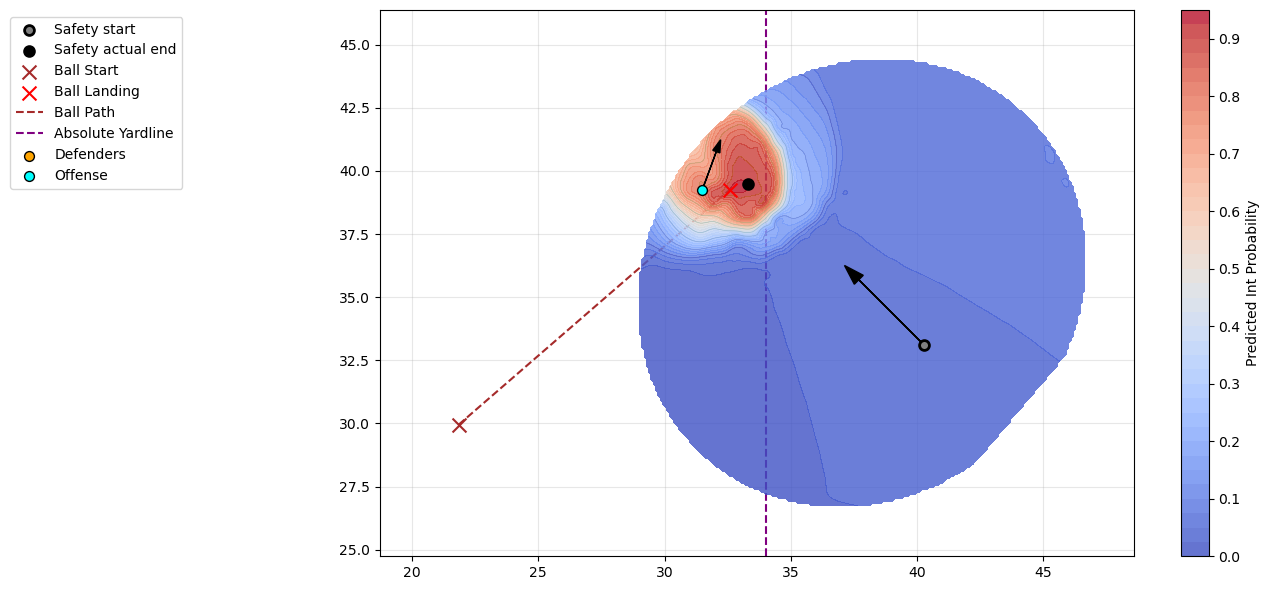

In [30]:
gpid = epa_results["gpid"].unique()[110]
example_df = epa_results[epa_results["gpid"] == gpid]
plot_safety_reach_heatmap(example_df, model_type="epa", tracking=tracking)

example_df = int_results[int_results["gpid"] == gpid]
plot_safety_reach_heatmap(example_df, model_type="int", tracking=tracking)

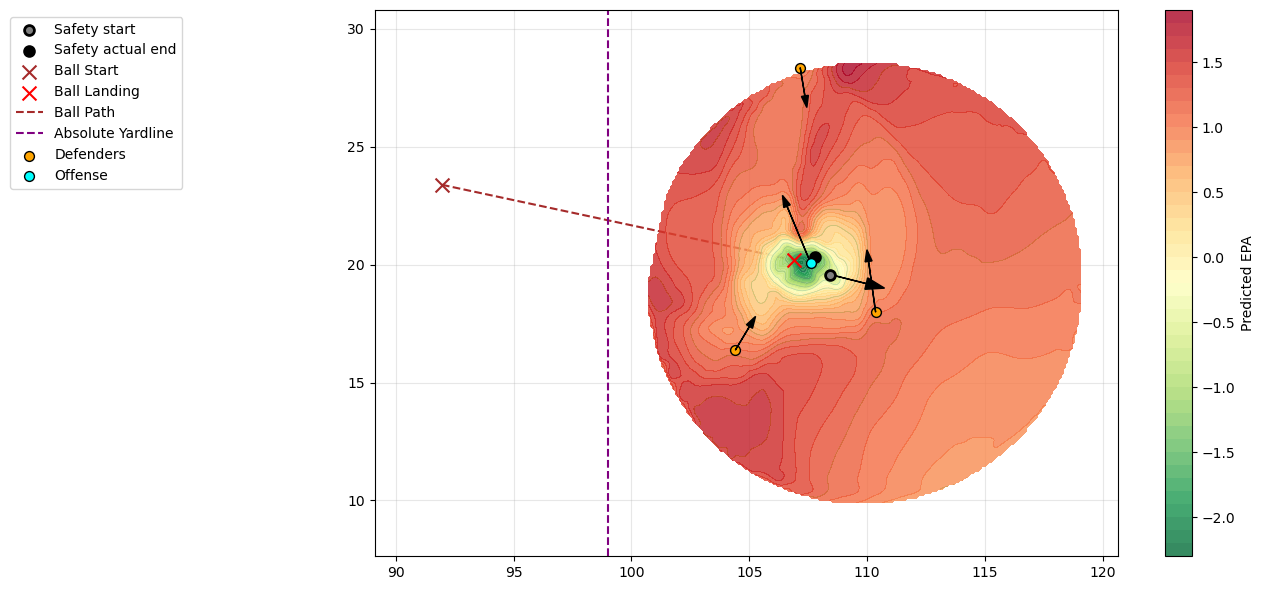

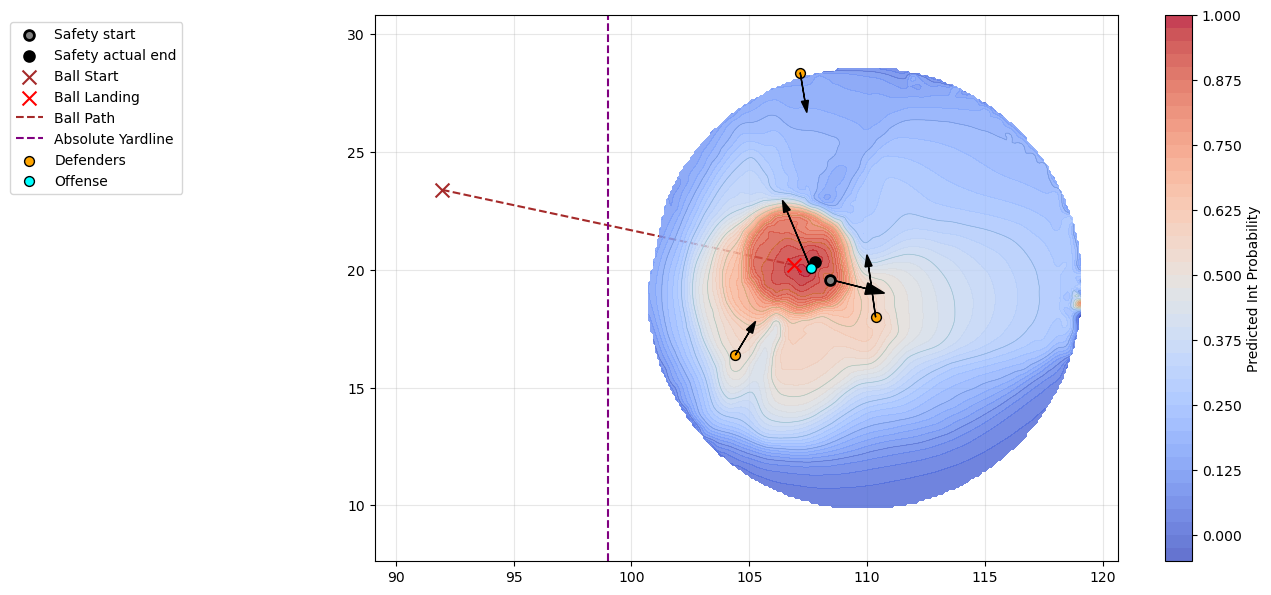

In [31]:
gpid = epa_results["gpid"].unique()[112]
example_df = epa_results[epa_results["gpid"] == gpid]
plot_safety_reach_heatmap(example_df, model_type="epa", tracking=tracking)

example_df = int_results[int_results["gpid"] == gpid]
plot_safety_reach_heatmap(example_df, model_type="int", tracking=tracking)

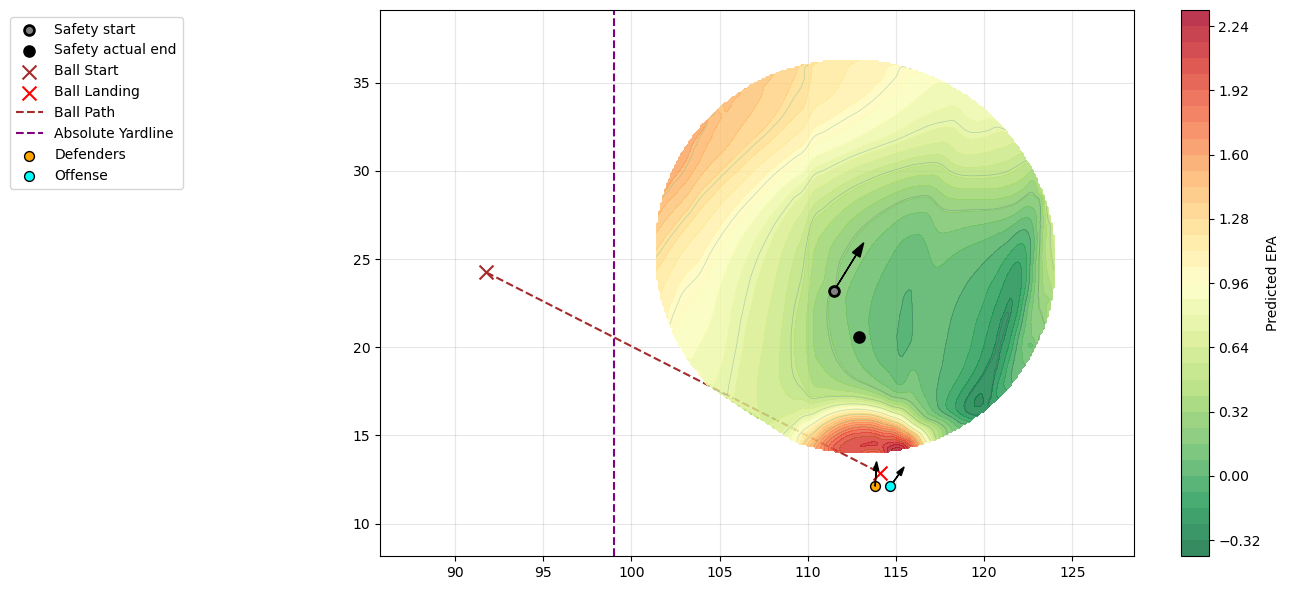

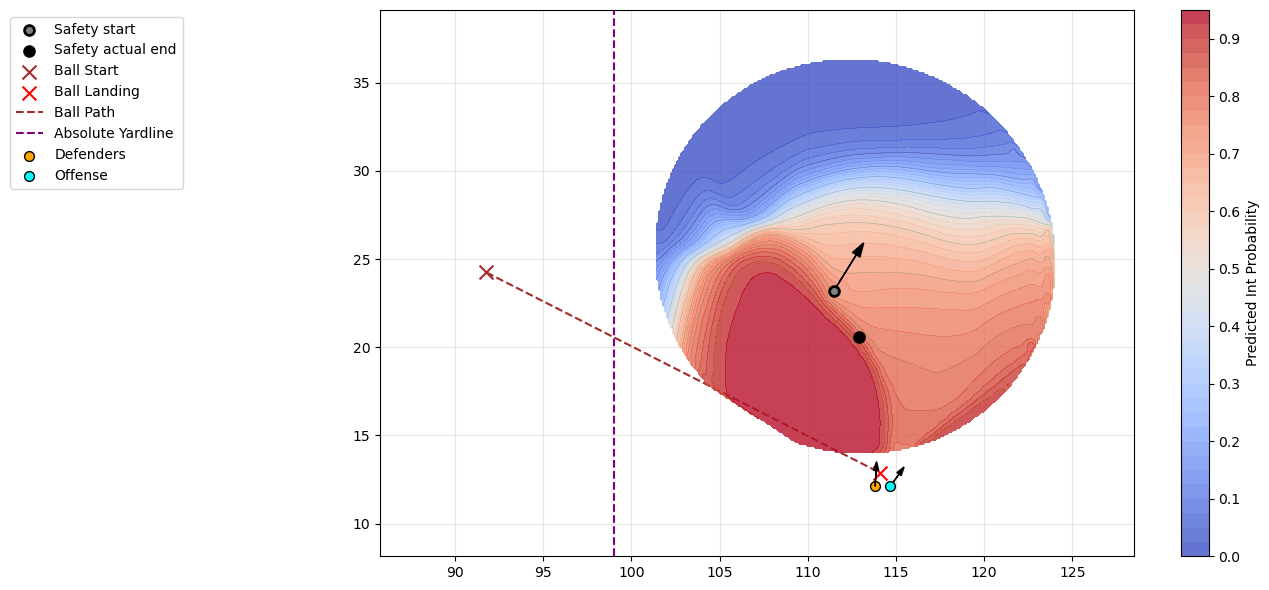

In [32]:
gpid = epa_results["gpid"].unique()[114]
example_df = epa_results[epa_results["gpid"] == gpid]
plot_safety_reach_heatmap(example_df, model_type="epa", tracking=tracking)
example_df = int_results[int_results["gpid"] == gpid]
plot_safety_reach_heatmap(example_df, model_type="int", tracking=tracking)

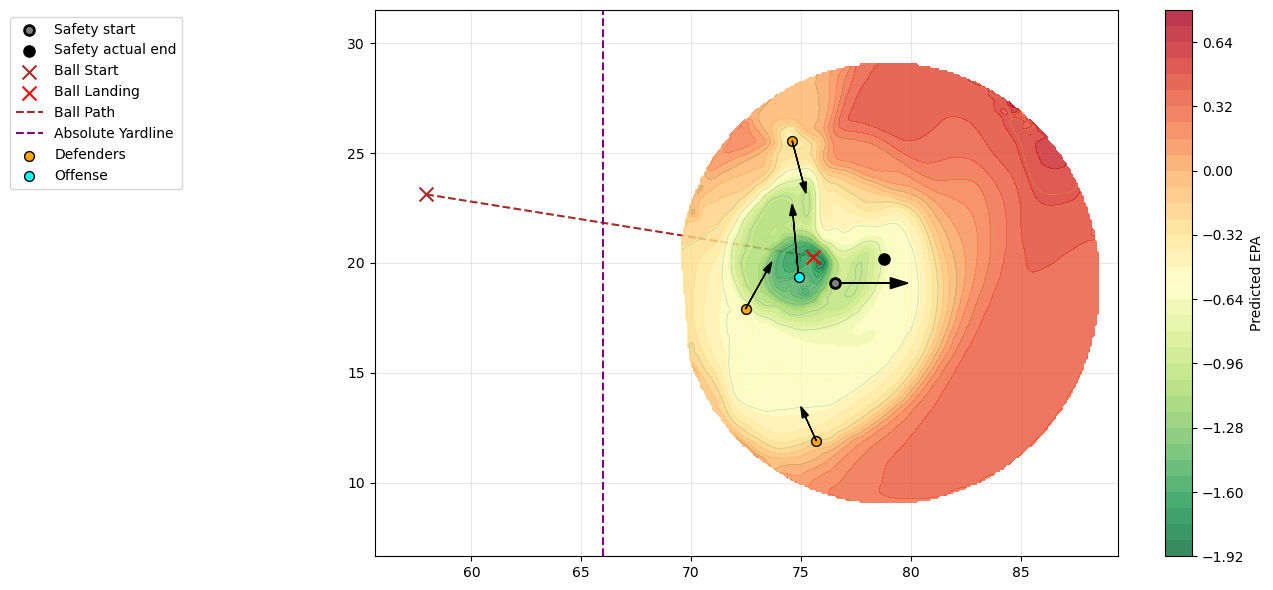

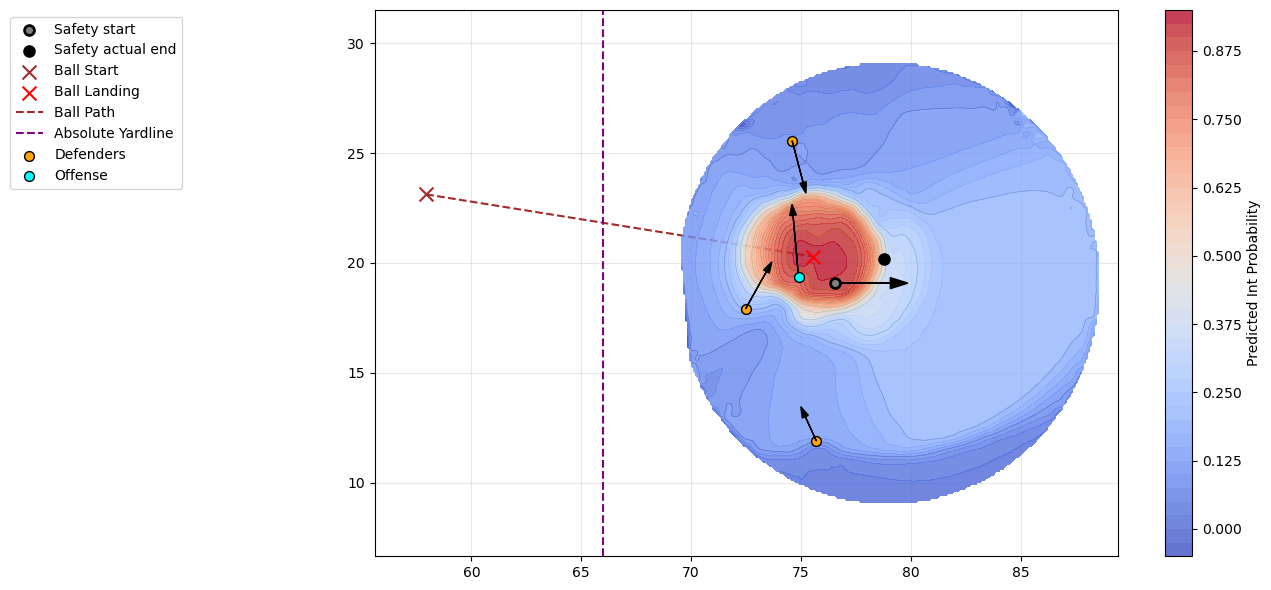

In [33]:
gpid = epa_results["gpid"].unique()[121]
example_df = epa_results[epa_results["gpid"] == gpid]
plot_safety_reach_heatmap(example_df, model_type="epa", tracking=tracking)

example_df = int_results[int_results["gpid"] == gpid]
plot_safety_reach_heatmap(example_df, model_type="int", tracking=tracking)

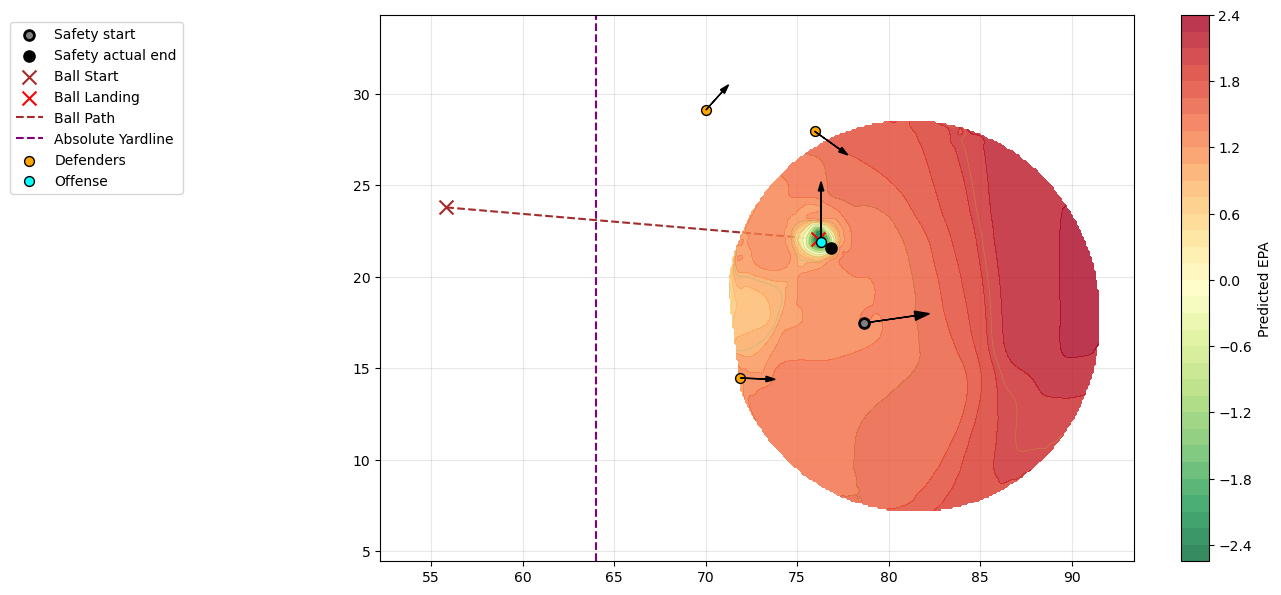

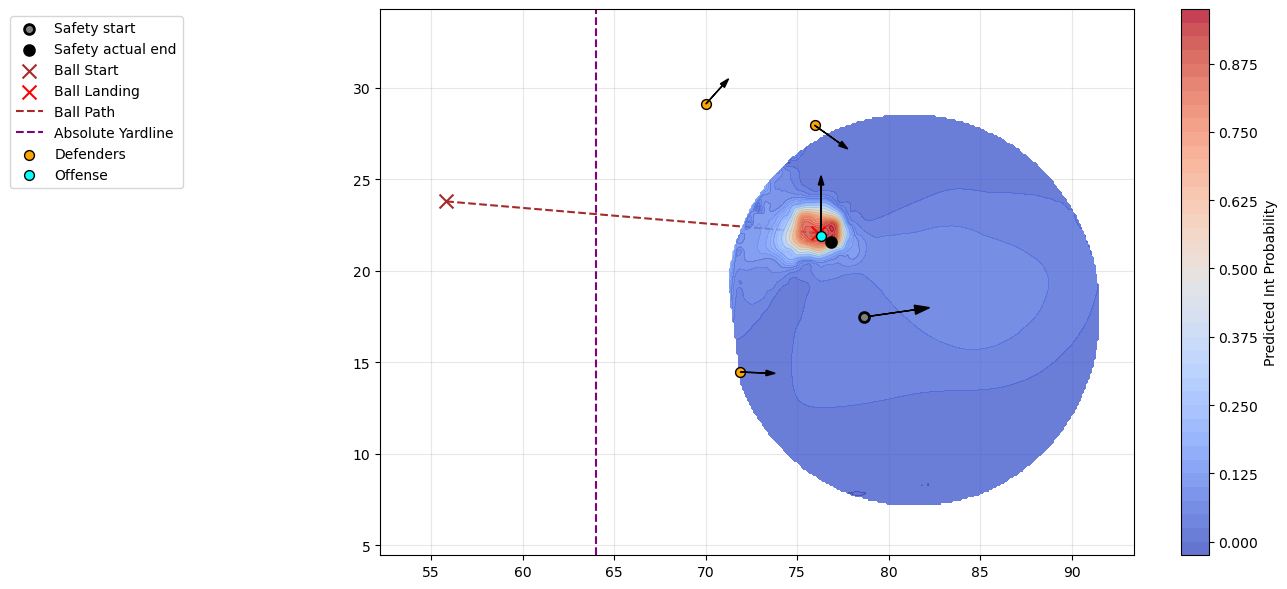

In [34]:
gpid = epa_results["gpid"].unique()[130]
example_df = epa_results[epa_results["gpid"] == gpid]
plot_safety_reach_heatmap(example_df, model_type="epa", tracking=tracking)

example_df = int_results[int_results["gpid"] == gpid]
plot_safety_reach_heatmap(example_df, model_type="int", tracking=tracking)

In [35]:
gpid = "2023091009_2499"
safety_nfl_id = 43387

original = epa_results.query(
    'gpid == @gpid & safety_nfl_id == @safety_nfl_id & sample_type == "original"'
)
simulated = epa_results.query(
    'gpid == @gpid & safety_nfl_id == @safety_nfl_id & sample_type == "simulated"'
)

act_epa = original.predicted_epa.values[0]
sim_epas = simulated.predicted_epa.values

# --- Original min/max Decision Efficiency ---
min_epa = sim_epas.min()
max_epa = sim_epas.max()
decision_eff_minmax = (max_epa - act_epa) / (max_epa - min_epa)

# --- Quantile-based Decision Efficiency ---
q_low, q_high = np.percentile(sim_epas, [10, 90])
decision_eff_quantile = (q_high - act_epa) / (q_high - q_low)

# --- Rank-based Decision Efficiency ---
rank = (sim_epas < act_epa).sum()  # how many simulated EPAs are better than actual
decision_eff_rank = 1 - rank / (len(sim_epas) - 1)

print(f"Actual EPA: {act_epa:.2f}")
print(f"Min EPA: {min_epa:.2f}, Max EPA: {max_epa:.2f}")
print(f"Decision Efficiency (min/max): {decision_eff_minmax:.2f}")
print(f"Decision Efficiency (quantile 10-90): {decision_eff_quantile:.2f}")
print(f"Decision Efficiency (rank-based): {decision_eff_rank:.2f}")

Actual EPA: 1.14
Min EPA: -2.42, Max EPA: 2.32
Decision Efficiency (min/max): 0.25
Decision Efficiency (quantile 10-90): 1.10
Decision Efficiency (rank-based): 0.93


In [40]:
import numpy as np

def compute_decision_efficiency(df, gpid, safety_nfl_id, model_type="epa"):
    """
    Compute multiple decision efficiency metrics for a safety's play.
    Rounds all results to 2 decimal places.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain 'predicted_epa' or 'predicted_int', 'sample_type',
        'gpid', 'safety_nfl_id'.
    gpid : str
        Play ID.
    safety_nfl_id : int
        Safety NFL ID.
    model_type : str
        "epa" or "int". Determines which column to use.

    Returns
    -------
    dict with actual value and three decision efficiency metrics.
    """
    pred_col = "predicted_epa" if model_type == "epa" else "predicted_int"

    original = df.query(
        'gpid == @gpid & safety_nfl_id == @safety_nfl_id & sample_type == "original"'
    )
    simulated = df.query(
        'gpid == @gpid & safety_nfl_id == @safety_nfl_id & sample_type == "simulated"'
    )

    act_val = original[pred_col].values[0]
    sim_vals = simulated[pred_col].values

    min_val = sim_vals.min()
    max_val = sim_vals.max()

    # --- Min/Max Decision Efficiency ---
    if model_type == "epa":
        decision_eff_minmax = (max_val - act_val) / (max_val - min_val)
    else:  # int probability
        decision_eff_minmax = (act_val - min_val) / (max_val - min_val)

    # --- Quantile-based Decision Efficiency (10th to 90th percentile) ---
    q_low, q_high = np.percentile(sim_vals, [10, 90])
    if model_type == "epa":
        decision_eff_quantile = (q_high - act_val) / (q_high - q_low)
    else:
        decision_eff_quantile = (act_val - q_low) / (q_high - q_low)

    # --- Rank-based Decision Efficiency ---
    if model_type == "epa":
        rank = (sim_vals < act_val).sum()  # smaller is better
    else:
        rank = (sim_vals > act_val).sum()  # larger is better
    decision_eff_rank = 1 - rank / (len(sim_vals) - 1)

    return {
        "actual": round(act_val, 2),
        "min": round(min_val, 2),
        "max": round(max_val, 2),
        "decision_eff_minmax": round(decision_eff_minmax, 2),
        "decision_eff_quantile": round(decision_eff_quantile, 2),
        "decision_eff_rank": round(decision_eff_rank, 2)
    }

import json

# --- Example usage ---
gpid = "2023091009_2499"
safety_nfl_id = 43387

epa_metrics = compute_decision_efficiency(epa_results, gpid, safety_nfl_id, model_type="epa")
int_metrics = compute_decision_efficiency(int_results, gpid, safety_nfl_id, model_type="int")

print("EPA Decision Efficiency:", json.dumps(epa_metrics, indent=2))
print("INT Probability Decision Efficiency:", json.dumps(int_metrics, indent=2))

EPA Decision Efficiency: {
  "actual": 1.14,
  "min": -2.42,
  "max": 2.32,
  "decision_eff_minmax": 0.25,
  "decision_eff_quantile": 1.1,
  "decision_eff_rank": 0.93
}
INT Probability Decision Efficiency: {
  "actual": 0.48,
  "min": 0.0,
  "max": 0.93,
  "decision_eff_minmax": 0.52,
  "decision_eff_quantile": 7.5,
  "decision_eff_rank": 0.98
}


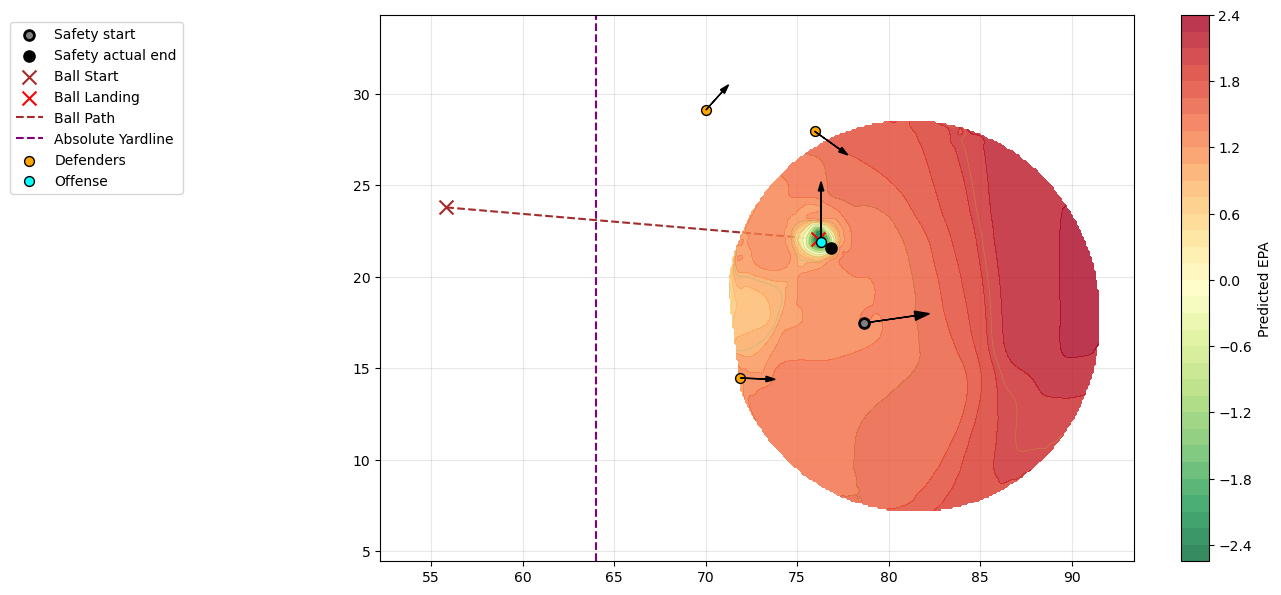

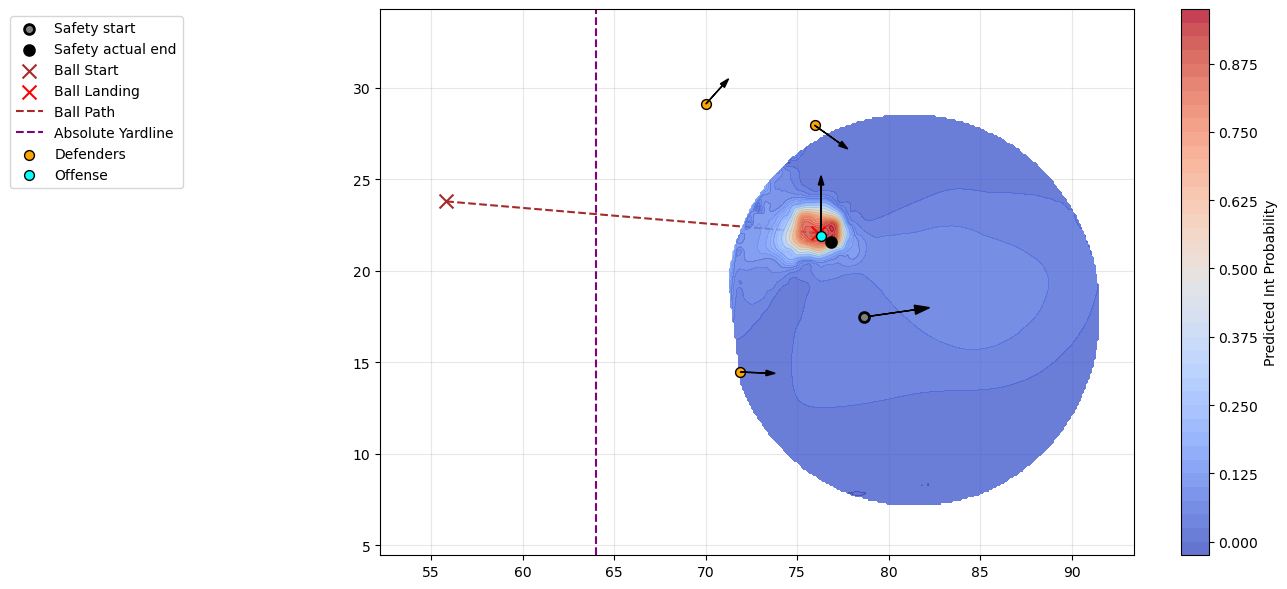

In [41]:
gpid = "2023091009_2499"
example_df = epa_results[epa_results["gpid"] == gpid]
plot_safety_reach_heatmap(example_df, model_type="epa", tracking=tracking)

example_df = int_results[int_results["gpid"] == gpid]
plot_safety_reach_heatmap(example_df, model_type="int", tracking=tracking)

In [42]:
plays.query('gpid == @gpid').play_description.values

array(['(7:20) (Shotgun) J.Garoppolo pass short middle to D.Adams to DEN 34 for 12 yards (J.Simmons) [Z.Allen].'],
      dtype=object)